**Reinforcement Learning with TensorFlow & TRFL: Generalized Lambda Returns**

Outline:
1. Generalized Lambda Returns
* TRFL Usage: trfl.generalized_lambda_returns() with CartPole
* TRFL Usage: trfl.generalized_lambda_returns() with LunarLander




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [1]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl==1.0

#install box2d for LunarLanding env
!pip install box2d-py

    100% |████████████████████████████████| 450kB 6.3MB/s 


In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

** Generalized Advantage Estimation (GAE) **

GAE is an exponentially weighted advantage function. GAE is similar to TD(λ) with advantages. GAE reduces variance greatly while adding an acceptable amount of bias. There is a bias variance trade-off between the λ weighted state estimates and the discount decayed returns. GAE can be used in policy gradient algorithms like we’ll see in this notebook. GAE is used in PPO.

** Generalized Lambda Returns **

The TRFL implementation of GAE: take the return of trfl.generalized_lambda_returns() and subtract the values argument.
Internally to TRFL: trfl.td_lambda() calls trfl.generalized_lambda_returns().
trfl.generalized_lambda_returns() can be viewed as a more general form of λ return methods like TD(λ).

In [0]:
class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64, 
               entropy_coefficient=0.01):
    
    with tf.variable_scope(name):
      self.name=name
      # set up placeholders
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.int32, [None], name='action')
      self.value_ = tf.placeholder(tf.float32, [None], name='values')
      
      # set up policy network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, action_size, activation_fn=None)

      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.fc3_)
      
      # TRFL usage
      self.pg_loss_ = trfl.discrete_policy_gradient(self.fc3_, self.action_, self.value_) 
      self.entropy_loss_, _ = trfl.discrete_policy_entropy_loss(self.fc3_, normalise=True)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      # Optimize the loss
      self.loss_ = tf.reduce_mean(self.combined_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
      
class ValueNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, hidden_size=64):
    
    with tf.variable_scope(name):
      self.name=name
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.target_ = tf.placeholder(tf.float32, [None, 1], name='targets')
      
      #set up value network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, 1, activation_fn=None)
      
      # optimizing the loss
      self.loss_ = tf.losses.mean_squared_error(self.fc3_, self.target_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
  def get_network_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

** TRFL Usage **

Generalized lambda returns the lambda returns. We subtract the values tensor to get GAE, which we use to train the policy network. trfl.td_lambda() calls trfl.generalized_lambda_returns() with the state_values from td_lambda become the values in generalized_lambda_returns(). We use the lambda returns to train the value network and update the target network with trfl.update_target_variables().

In [0]:
# hyperparameters
discount = 0.99
lambda_val = 0.90

train_episodes = 5000                     

hidden_size = 32
learning_rate = 0.001
value_learning_rate = 0.001
entropy_coefficient = 0.0001
update_tau = 0.001

seed = 31
env = gym.make('CartPole-v0')
env.seed(seed)
np.random.seed(seed)

action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)

# Create networks
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=learning_rate, 
                           entropy_coefficient=entropy_coefficient)
value_net = ValueNetwork(name='value_net', hidden_size=hidden_size, obs_size=obs_size, 
                         learning_rate=value_learning_rate)
target_value_net = ValueNetwork(name='target_net', hidden_size=hidden_size, obs_size=obs_size, 
                         learning_rate=value_learning_rate)

#target network updating
target_network_update_op = trfl.update_target_variables(target_value_net.get_network_variables(), 
                                                         value_net.get_network_variables(), tau=update_tau)

# generalized lambda returns set up
reward_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_reward" )
discount_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_discount" )
value_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_value" )
bootstrap_ = tf.placeholder(dtype=tf.float32, shape=[None], name="glr_bootstrap" )
#lambda_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_lambda" )
gen_lambda_return_ = trfl.generalized_lambda_returns(reward_, discount_, value_, bootstrap_, lambda_=lambda_val)


In [5]:
stats_rewards_list = []
stats_every = 10

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = env.reset() 
        done = 0
        
        # store trajectories in lists, use trajectories to train agent
        obs_list, rew_list, action_list, total_loss_list = [], [], [], []
        
        # stop episodes when agent is able to solve game
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 190:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            # generate action probabilities from policy net and sample from the action probs
            action_probs = sess.run(policy_net.action_prob_, feed_dict={policy_net.input_: 
                                                                        np.expand_dims(state,axis=0)})
            action_probs = action_probs[0]
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
            obs_list.append(state)
            action_list.append(action)
            
            state, reward, done, info = env.step(action)
            total_reward += reward
            ep_length += 1
            rew_list.append(reward)
            
            # bootstrap value for next state using target network
            if done:
              bootstrap_value = 0.
            else:
              bootstrap_value = sess.run(target_value_net.fc3_, feed_dict={
                    target_value_net.input_:np.reshape(state,(1,-1)),
                })
              bootstrap_value = bootstrap_value[0]
          
            # run value network to get baseline predictions
            baselines = sess.run(value_net.fc3_, feed_dict={
                value_net.input_:np.array(obs_list),
            })
            baselines = np.reshape(baselines,(-1, 1))

            # get lambda values from generalized lambda returns
            lambda_returns = sess.run(gen_lambda_return_, feed_dict={
              reward_:np.array(rew_list).reshape(-1,1),
              value_:np.array(baselines).reshape(-1,1),
              discount_:np.array([discount]*len(rew_list)).reshape(-1,1),
              bootstrap_:np.array(bootstrap_value).reshape((1,))
            })

            # advantage of generalized lambda returns over baselines
            advantage = lambda_returns - baselines
            
            # train policy network with advantage
            _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                     feed_dict={ policy_net.input_: np.array(obs_list),
                                               policy_net.action_: np.array(action_list,dtype=np.int32),
                                               policy_net.value_: np.reshape(advantage,(-1))} )
            total_loss_list.append(stats_loss)

            # train value network using lambda returns
            value_loss, _ = sess.run([value_net.loss_, value_net.optim_], feed_dict={
                value_net.input_:np.array(obs_list),
                value_net.target_:lambda_returns
            })

            # update target network
            sess.run(target_network_update_op)
            
            if done:
              if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                      'Ep length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                      'Loss: {:.4f}'.format(np.mean(total_loss_list)))
              stats_rewards_list.append((ep, total_reward, ep_length))
                

Episode: 10 Total reward: 32.8 Ep length: 32.8 Loss: -6.6693
Episode: 20 Total reward: 30.2 Ep length: 30.2 Loss: 0.9242
Episode: 30 Total reward: 31.6 Ep length: 31.6 Loss: -0.1469
Episode: 40 Total reward: 51.0 Ep length: 51.0 Loss: 1.2703
Episode: 50 Total reward: 63.7 Ep length: 63.7 Loss: -7.3984
Episode: 60 Total reward: 15.4 Ep length: 15.4 Loss: -0.0756
Episode: 70 Total reward: 14.1 Ep length: 14.1 Loss: -0.2079
Episode: 80 Total reward: 15.7 Ep length: 15.7 Loss: -0.6328
Episode: 90 Total reward: 17.4 Ep length: 17.4 Loss: 0.5361
Episode: 100 Total reward: 31.3 Ep length: 31.3 Loss: 0.7284
Episode: 110 Total reward: 48.3 Ep length: 48.3 Loss: -1.8293
Episode: 120 Total reward: 83.9 Ep length: 83.9 Loss: 0.7972
Episode: 130 Total reward: 98.4 Ep length: 98.4 Loss: 0.1589
Episode: 140 Total reward: 62.7 Ep length: 62.7 Loss: -1.3426
Episode: 150 Total reward: 58.6 Ep length: 58.6 Loss: 0.0457
Episode: 160 Total reward: 116.6 Ep length: 116.6 Loss: -0.0015
Episode: 170 Total rew

Text(0, 0.5, 'Total Reward')

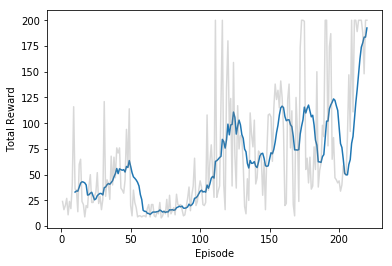

In [6]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 2: Generalized Lambda Returns and Policy Gradients with LunarLander **

In [0]:
class PolicyNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, action_size=3, hidden_size=64, 
               entropy_coefficient=0.01):
    
    with tf.variable_scope(name):
      self.name=name
      # set up placeholders
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.int32, [None], name='action')
      self.value_ = tf.placeholder(tf.float32, [None], name='values')
      
      # set up policy network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, action_size, activation_fn=None)

      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.fc3_)
      
      # TRFL usage
      self.pg_loss_ = trfl.discrete_policy_gradient(self.fc3_, self.action_, self.value_) 
      self.entropy_loss_, _ = trfl.discrete_policy_entropy_loss(self.fc3_, normalise=True)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      # Optimize the loss
      self.loss_ = tf.reduce_mean(self.combined_loss_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
      
class ValueNetwork:
  def __init__(self, name, learning_rate=0.001, obs_size=2, hidden_size=64):
    
    with tf.variable_scope(name):
      self.name=name
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.target_ = tf.placeholder(tf.float32, [None, 1], name='targets')
      
      #set up value network
      self.fc1_ = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
      self.fc2_ = tf.contrib.layers.fully_connected(self.fc1_, hidden_size, activation_fn=tf.nn.relu)
      self.fc3_ = tf.contrib.layers.fully_connected(self.fc2_, 1, activation_fn=None)
      
      # optimizing the loss
      self.loss_ = tf.losses.mean_squared_error(self.fc3_, self.target_)
      self.optim_ = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_)
      
  def get_network_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

In [0]:
# hyperparameters
discount = 0.99
lambda_val = 0.90

train_episodes = 5000                     

hidden_size = 32
learning_rate = 0.0001
value_learning_rate = 0.001
entropy_coefficient = 0.00001
update_tau = 0.001

seed = 31
env = gym.make('LunarLander-v2')
env.seed(seed)
np.random.seed(seed)

action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)

# Create networks
policy_net = PolicyNetwork(name='policy_net', hidden_size=hidden_size, obs_size=obs_size,
                          action_size=action_size, learning_rate=learning_rate, 
                           entropy_coefficient=entropy_coefficient)
value_net = ValueNetwork(name='value_net', hidden_size=hidden_size, obs_size=obs_size, 
                         learning_rate=value_learning_rate)
target_value_net = ValueNetwork(name='target_net', hidden_size=hidden_size, obs_size=obs_size, 
                         learning_rate=value_learning_rate)

#target network updating
target_network_update_op = trfl.update_target_variables(target_value_net.get_network_variables(), 
                                                         value_net.get_network_variables(), tau=update_tau)

# generalized lambda returns set up
reward_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_reward" )
discount_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_discount" )
value_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_value" )
bootstrap_ = tf.placeholder(dtype=tf.float32, shape=[None], name="glr_bootstrap" )
#lambda_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="glr_lambda" )
gen_lambda_return_ = trfl.generalized_lambda_returns(reward_, discount_, value_, bootstrap_, 
                                                     lambda_=lambda_val)


In [9]:
stats_rewards_list = []
stats_every = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward = 0
        ep_length = 0
        state = env.reset() 
        state = np.clip(state, -1.0, 1.0) #clip state within useful range of values
        done = 0
        
        # store trajectories in lists, use trajectories to train agent
        obs_list, rew_list, action_list, total_loss_list = [], [], [], []
        
        # stop episodes when agent is able to solve game
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 190:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            # generate action probabilities from policy net and sample from the action probs
            action_probs = sess.run(policy_net.action_prob_, feed_dict={policy_net.input_: 
                                                                        np.expand_dims(state,axis=0)})
            action_probs = action_probs[0]
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
            obs_list.append(state)
            action_list.append(action)
            
            state, reward, done, info = env.step(action)
            total_reward += reward
            ep_length += 1
            state = np.clip(state, -1.0, 1.0)
            # scale rewards
            reward *= .01
            reward = np.clip(reward, -10., 10.)
            rew_list.append(reward)
            
            # bootstrap value for next state using target network
            if done:
              bootstrap_value = 0.
            else:
              bootstrap_value = sess.run(target_value_net.fc3_, feed_dict={
                    target_value_net.input_:np.reshape(state,(1,-1)),
                })
              bootstrap_value = bootstrap_value[0]
          
            if total_reward < -250:
              done = 1
              
            # run value network to get baseline predictions
            baselines = sess.run(value_net.fc3_, feed_dict={
                value_net.input_:np.array(obs_list),
            })
            baselines = np.reshape(baselines,(-1, 1))

            # get lambda values from generalized lambda returns
            lambda_returns = sess.run(gen_lambda_return_, feed_dict={
              reward_:np.array(rew_list).reshape(-1,1),
              value_:np.array(baselines).reshape(-1,1),
              discount_:np.array([discount]*len(rew_list)).reshape(-1,1),
              bootstrap_:np.array(bootstrap_value).reshape((1,))
            })

            # advantage of generalized lambda returns over baselines
            advantage = lambda_returns - baselines
            
            # train policy on advantage
            _, stats_loss = sess.run([policy_net.optim_, policy_net.loss_], 
                                     feed_dict={ policy_net.input_: np.array(obs_list),
                                               policy_net.action_: np.array(action_list,dtype=np.int32),
                                               policy_net.value_: np.reshape(advantage,(-1))} )
            total_loss_list.append(stats_loss)
            # train value network using lambda returns
            value_loss, _ = sess.run([value_net.loss_, value_net.optim_], feed_dict={
                value_net.input_:np.array(obs_list),
                value_net.target_:lambda_returns
            })
            # update target network
            sess.run(target_network_update_op)
            
            if done:
              if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                      'Ep length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                      'Loss: {:.4f}'.format(np.mean(total_loss_list)))
              stats_rewards_list.append((ep, total_reward, ep_length))
                

Episode: 10 Total reward: -175.9 Ep length: 85.1 Loss: -0.0183
Episode: 20 Total reward: -120.7 Ep length: 94.9 Loss: -0.0413
Episode: 30 Total reward: -180.2 Ep length: 94.6 Loss: -0.0432
Episode: 40 Total reward: -142.3 Ep length: 103.3 Loss: -0.0035
Episode: 50 Total reward: -114.7 Ep length: 95.1 Loss: -0.0038
Episode: 60 Total reward: -131.1 Ep length: 85.5 Loss: -0.0080
Episode: 70 Total reward: -120.8 Ep length: 93.2 Loss: -0.0042
Episode: 80 Total reward: -94.7 Ep length: 88.1 Loss: 0.0021
Episode: 90 Total reward: -87.6 Ep length: 110.2 Loss: 0.0002
Episode: 100 Total reward: -108.9 Ep length: 150.8 Loss: 0.0024
Episode: 110 Total reward: -75.3 Ep length: 280.0 Loss: -0.0107
Episode: 120 Total reward: -30.5 Ep length: 225.2 Loss: 0.0010
Episode: 130 Total reward: -20.0 Ep length: 155.8 Loss: -0.0004
Episode: 140 Total reward: 2.8 Ep length: 260.8 Loss: -0.0046
Episode: 150 Total reward: -4.2 Ep length: 142.8 Loss: -0.0011
Episode: 160 Total reward: 40.2 Ep length: 430.5 Loss: 

Text(0, 0.5, 'Total Reward')

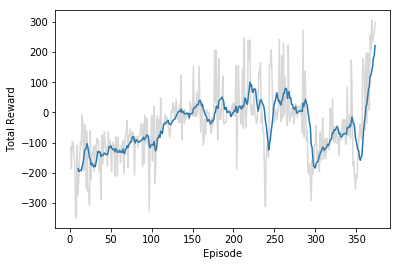

In [10]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')